# Welcome to the Lab 🥼🧪

## Market Analysis 

Let's do a deep dive on one specific market, your choice. 

Let's get into the lab and take a peak at whats going on. 

**Note** This notebook will work with any of the 70k+ markets supported by the Parcl Labs API.

As a reminder, you can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along. 

To run this immediately, you can use Google Colab. Remember, you must set your `PARCL_LABS_API_KEY` as a secret. See this [guide](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75) for more information.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ParclLabs/parcllabs-examples/blob/main/python/market_analysis.ipynb)

## Table of Contents

### [Market Overview](#market)
- Housing Stock/Mix Analysis
- Percent of Overall Market Owned by Investors
- Market Overview: Percent of all units that are rentals
- Who owns the homes? Size of investors in the market

### [Listing Overview](#listings)
- New listings analysis
- Of listings, what share do investors account for?

### [Prices Overview](#prices)
- Rental Prices
- New Listing for Sale Prices
- Purchase Prices

We will be creating charts like this: 

![Chart1](assets/purchase_price_vs_list_price.png)
![Chart2](assets/rental_listing_price.png)
![Chart3](assets/single_family_homes_percentage.png)

In [10]:
# Environment setup
import os
import sys
import subprocess
from datetime import datetime

# Collab setup from one click above
if "google.colab" in sys.modules:
    from google.colab import userdata
    %pip install parcllabs plotly kaleido
    api_key = userdata.get('PARCL_LABS_API_KEY')
else:
    api_key = os.getenv('PARCL_LABS_API_KEY')

In [11]:
import parcllabs
import pandas as pd
import plotly.express as px
from parcllabs import ParclLabsClient

print(f"Parcl Labs Version: {parcllabs.__version__}")

Parcl Labs Version: 0.1.16


In [37]:
client = ParclLabsClient(api_key=api_key)

In [38]:
# we are looking at homes in San Diego, so we look for the name and the type of market
results = client.search_markets.retrieve(
    query='San Diego',
    location_type='CITY',
    as_dataframe=True
)

results.head()

,parcl_id,country,geoid,state_fips_code,name,state_abbreviation,region,location_type,total_population,median_income,parcl_exchange_market,pricefeed_market,case_shiller_10_market,case_shiller_20_market
0,5374167,USA,0666000,06,San Diego City,CA,PACIFIC,CITY,1383987,98657,0,1,0,0
1,5316648,USA,4865180,48,San Diego City,TX,WEST_SOUTH_CENTRAL,CITY,3801,46620,0,0,0,0


In [39]:
# we see that the the first result is the city of San Diego, so we will use the parcl id of 5374167
analysis_parcl_id = results.iloc[0]['parcl_id']
name = results.iloc[0]['name']

# set default save directory
save_dir = './graphics'
new_dir_name = f"{analysis_parcl_id}-{name}-{datetime.today().date()}"
output_dir = os.path.join(save_dir, new_dir_name)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"In this analysis, we are studying: {name} which has parcl id: {analysis_parcl_id}. Saving graphics to: {save_dir}")

In this analysis, we are studying: San Diego City which has parcl id: 5374167. Saving graphics to: ./graphics


<a id='market'></a>
#### Market Overview

Let's review housing stock mix, percent of housing stock owned by investors, and percent of all units that are rentals.

In [40]:
# we call the API specifying the parcl id and the necessary parameters
housing_stock = client.market_metrics_housing_stock.retrieve(
    parcl_id=analysis_parcl_id,
    params={
        'limit': 100
    },
    as_dataframe=True # set to true to default to a pandas dataframe for easier manipulation
)

housing_stock.head()

,date,single_family,condo,townhouse,other,all_properties,parcl_id
0,2024-03-01,216661,163945,2717,46806,430129,5374167
1,2024-02-01,216659,163935,2716,46801,430111,5374167
2,2024-01-01,216658,163928,2715,46798,430099,5374167
3,2023-12-01,216652,163909,2714,46793,430068,5374167
4,2023-11-01,216646,163886,2714,46790,430036,5374167


In [41]:
# calculate the percentage of each property type
housing_stock['pct_condo'] = housing_stock['condo']/housing_stock['all_properties']
housing_stock['pct_townhouse'] = housing_stock['townhouse']/housing_stock['all_properties']
housing_stock['pct_single_family'] = housing_stock['single_family']/housing_stock['all_properties']
housing_stock['pct_other'] = housing_stock['other']/housing_stock['all_properties']
housing_stock.head()

,date,single_family,condo,townhouse,other,all_properties,parcl_id,pct_condo,pct_townhouse,pct_single_family,pct_other
0,2024-03-01,216661,163945,2717,46806,430129,5374167,0.381153,0.006317,0.503712,0.108819
1,2024-02-01,216659,163935,2716,46801,430111,5374167,0.381146,0.006315,0.503728,0.108811
2,2024-01-01,216658,163928,2715,46798,430099,5374167,0.381140,0.006313,0.503740,0.108808
3,2023-12-01,216652,163909,2714,46793,430068,5374167,0.381123,0.006311,0.503762,0.108804
4,2023-11-01,216646,163886,2714,46790,430036,5374167,0.381098,0.006311,0.503786,0.108805



Let's analyze how the percent of single family homes as a proportion of the overall housing stock has changed
since 2019 in San Diego. The API returns monthly data for this endpoint since January 2019. We will see how the supply of housing has changed over the last 5 years. 

In [42]:
# set some constants for the analysis, such as the logo for the chart, we have a white and blue version
labs_logo_lookup = {
    'blue': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api.png',
    'white': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api-logo-white.png'
}

# set charting constants
labs_logo_dict = dict(
        source=labs_logo_lookup['white'],
        xref="paper",
        yref="paper",
        x=0.5,  # Centering the logo below the title
        y=1.02,  # Adjust this value to position the logo just below the title
        sizex=0.15, 
        sizey=0.15,
        xanchor="center",
        yanchor="bottom"
)

# define image dimentions
media_img_size_lookup = {
    'X': {
        'width': 1600,
        'height': 900
    }
}

# optimize the visual for the platform in this case X
PLATFORM = 'X'

# set image sizes
IMG_WIDTH = media_img_size_lookup[PLATFORM]['width']
IMG_HEIGHT = media_img_size_lookup[PLATFORM]['height']

# plotting title settings
PLOT_TITLE_SETTINGS = {
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }

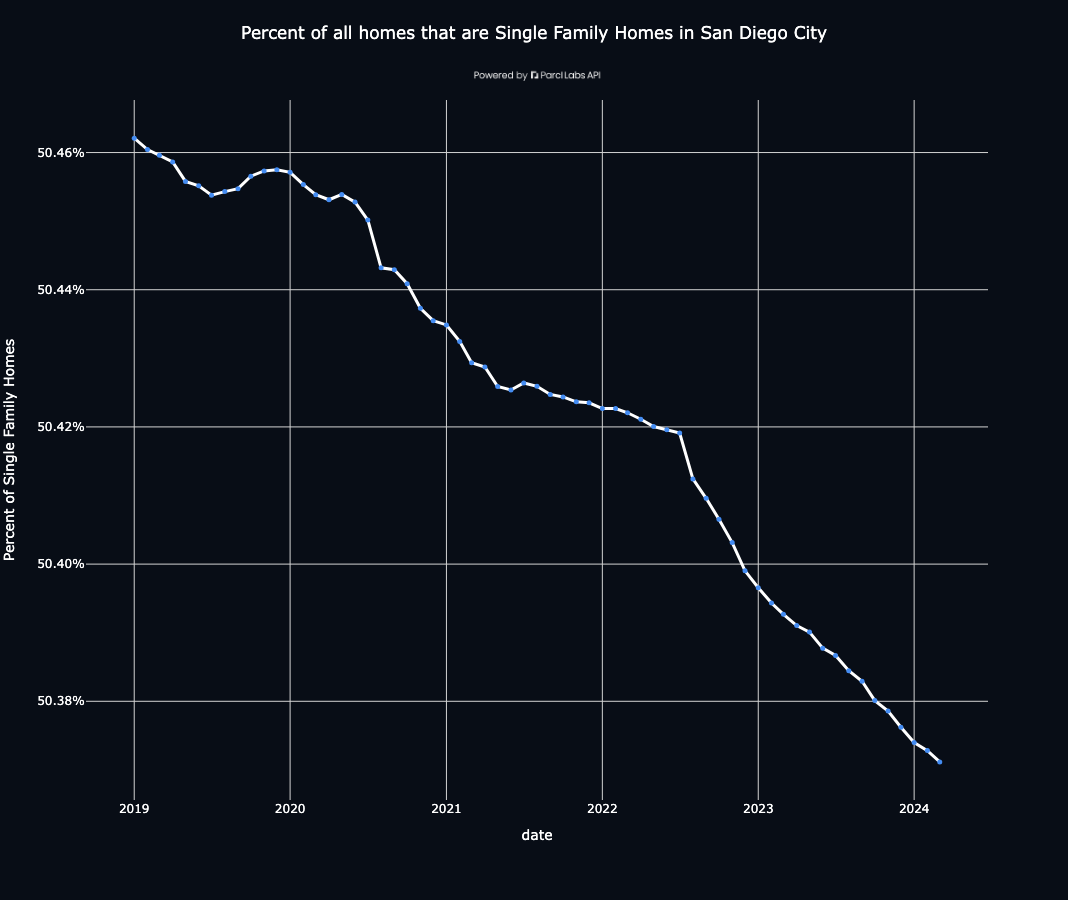

In [43]:
# Creating the line chart
fig = px.line(
    housing_stock, 
    x='date', 
    y='pct_single_family', 
    title=f'Percent of all homes that are Single Family Homes in {name}',
    labels={'pct_single_family': 'Percent of Single Family Homes'}
)

# Showing the plot
# Add the logo as a layout_image
fig.add_layout_image(
    labs_logo_dict
)

fig.update_layout(
    margin=dict(b=100),
    width=IMG_WIDTH,
    height=IMG_HEIGHT,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top',
        title='Rolling Window (Days)'
    ),
    title=PLOT_TITLE_SETTINGS,
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    xaxis_title='date'
)

fig.update_traces(
    line=dict(color='#FFFFFF', width=3),
    mode='lines+markers',
    marker=dict(color='#448CF2', size=5)
)


# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(tickformat=".2%")

# save fig
fig.write_image(os.path.join(output_dir, 'percent_single_family_homes.png'), width=IMG_WIDTH, height=IMG_HEIGHT)
# Show the plot
fig.show()

In [44]:
# Now lets find out how much of the housing stock is owned by investors in San Diego
investor_ownership = client.investor_metrics_housing_stock_ownership.retrieve(
    parcl_id=analysis_parcl_id,
    params={
        'limit': 200,
    },
    as_dataframe=True
)

# the results returned by the API are in percentage points, howver for graph formatting we divide pct_ownership 
# so plotly can handles this internally
investor_ownership['pct_ownership'] = investor_ownership['pct_ownership']/100

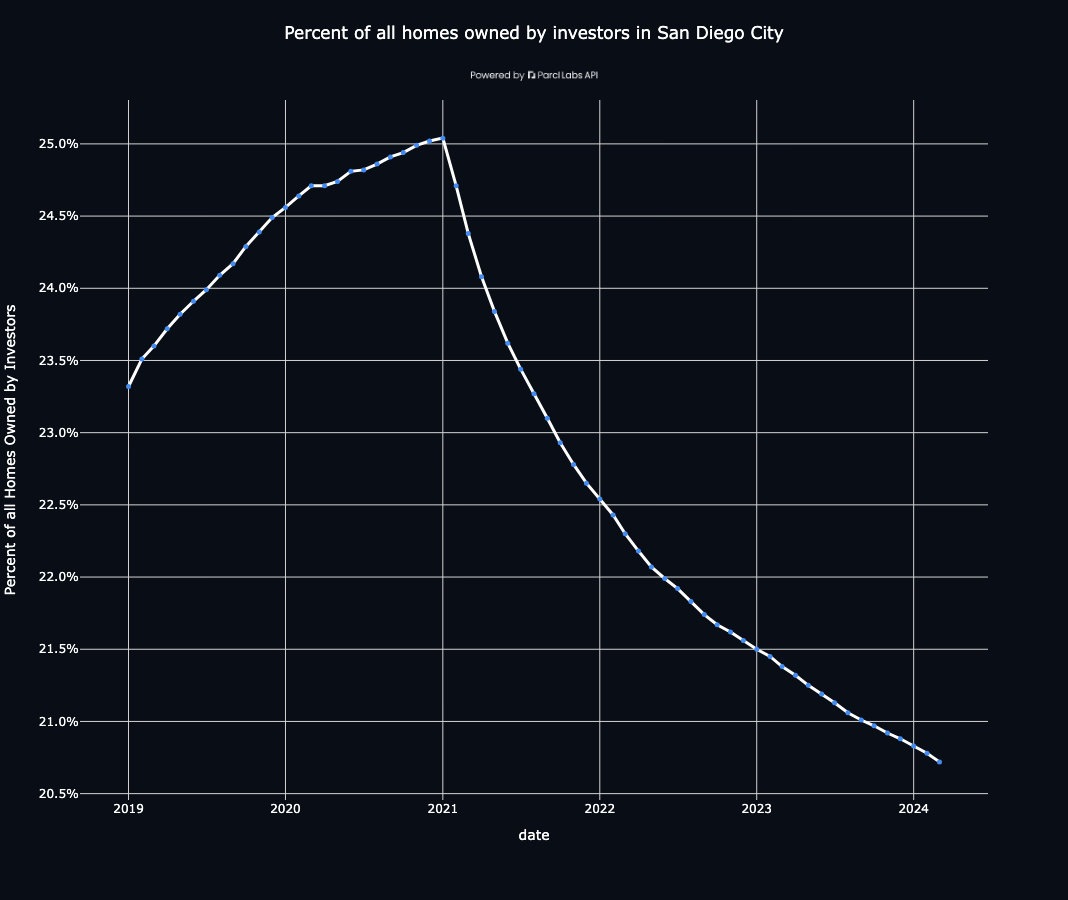

In [45]:
# Creating the line chart
fig = px.line(
    investor_ownership, 
    x='date', 
    y='pct_ownership', 
    title=f'Percent of all homes owned by investors in {name}',
    labels={'pct_ownership': 'Percent of all Homes Owned by Investors'}
)

# Showing the plot
# Add the logo as a layout_image
fig.add_layout_image(
    labs_logo_dict
)

fig.update_layout(
    margin=dict(b=100),
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top',
        title='Rolling Window (Days)'
    ),
    title=PLOT_TITLE_SETTINGS,
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    xaxis_title='date'
)

fig.update_traces(
    line=dict(color='#FFFFFF', width=3),
    mode='lines+markers',
    marker=dict(color='#448CF2', size=5)
)


# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(tickformat=".1%")

# save
fig.write_image(os.path.join(output_dir, 'percent_all_homes_owned_by_investors.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()

We can see that 1 in 5 homes in the San Diego market are owned by investors. That concentration is not evenly distributed among property types. Lets now analyze the ownership structure of Single Family Homes by portfolio size of the investors that own these properties. 

In [46]:
# lets retrieve the portfolio size ownership metrics
portfolio_size_ownership = client.portfolio_metrics_sf_housing_stock_ownership.retrieve(
    parcl_id=analysis_parcl_id,
    as_dataframe=True
)

portfolio_size_ownership.head()

,date,count_portfolio_2_to_9,count_portfolio_10_to_99,count_portfolio_100_to_999,count_portfolio_1000_plus,count_all_portfolios,pct_sf_housing_stock_portfolio_2_to_9,pct_sf_housing_stock_portfolio_10_to_99,pct_sf_housing_stock_portfolio_100_to_999,pct_sf_housing_stock_portfolio_1000_plus,pct_sf_housing_stock_all_portfolios,parcl_id
0,2024-03-01,22783,755,11,115,23664,10.52,0.35,0.01,0.05,10.92,5374167


In [47]:
# lets focus on the percentages, so we create a subset of the data
pso_pcts = portfolio_size_ownership[[
    'date', 
    'pct_sf_housing_stock_portfolio_2_to_9', 
    'pct_sf_housing_stock_portfolio_10_to_99', 
    'pct_sf_housing_stock_portfolio_100_to_999',
    'pct_sf_housing_stock_portfolio_1000_plus',
    'pct_sf_housing_stock_all_portfolios'
]]

# do some data wrangling to make the data long format and divide by 100 so plotly can handle the formatting
pso_pcts_long = pso_pcts.melt(id_vars=['date'], var_name='category', value_name='percentage')
pso_pcts_long['percentage'] = pso_pcts_long['percentage']/100

# rename to friendly labels
friendly_labels = {
    'pct_sf_housing_stock_portfolio_2_to_9': 'Investor Portfolio (2 to 9 Units)', 
    'pct_sf_housing_stock_portfolio_10_to_99': 'Investor Portfolio (10 to 99 Units)', 
    'pct_sf_housing_stock_portfolio_100_to_999': 'Investor Portfolio (100 to 999 Units)',
    'pct_sf_housing_stock_portfolio_1000_plus': 'Investor Portfolio (1000+ Units)',
    'pct_sf_housing_stock_all_portfolios': 'Investor Portfolio (All Sizes)'
}

pso_pcts_long['category'] = pso_pcts_long['category'].replace(friendly_labels)
pso_pcts_long.head()

,date,category,percentage
0,2024-03-01,Investor Portfolio (2 to 9 Units),0.1052
1,2024-03-01,Investor Portfolio (10 to 99 Units),0.0035
2,2024-03-01,Investor Portfolio (100 to 999 Units),0.0001
3,2024-03-01,Investor Portfolio (1000+ Units),0.0005
4,2024-03-01,Investor Portfolio (All Sizes),0.1092


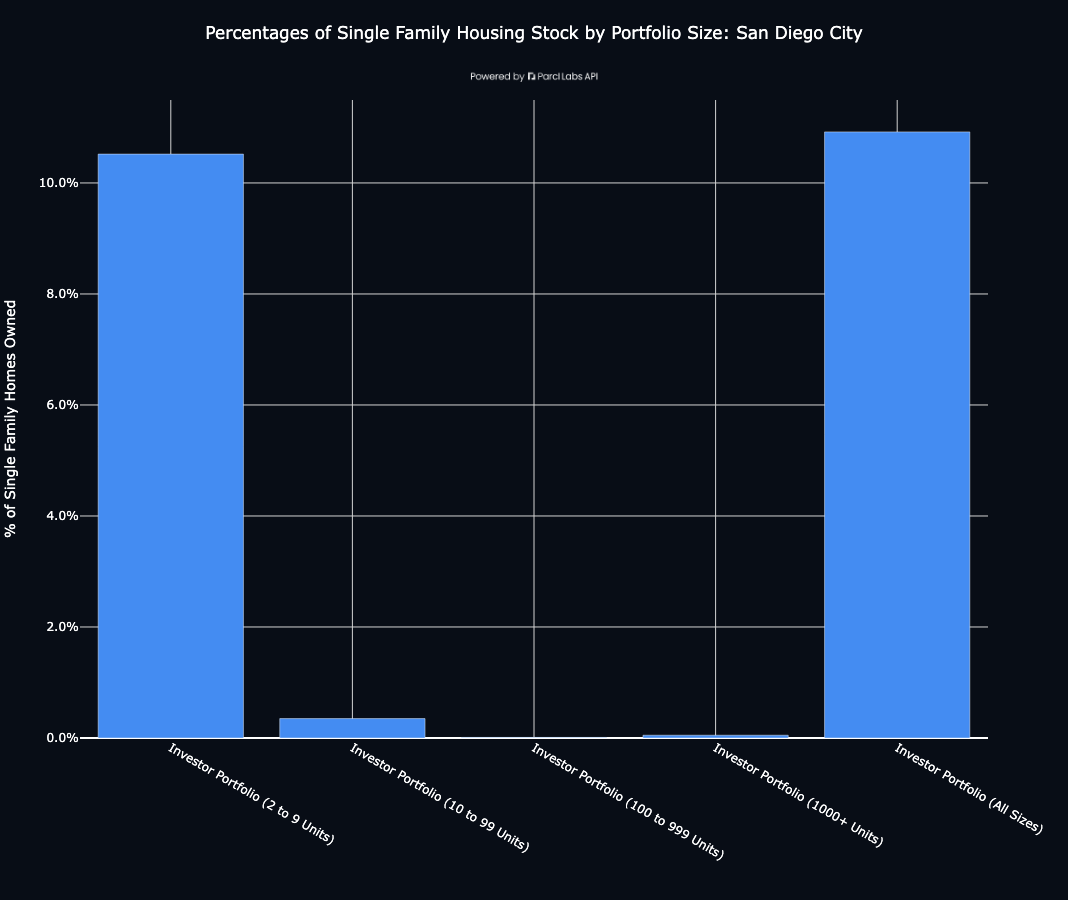

In [48]:
# Creating the bar chart
fig = px.bar(
    pso_pcts_long,
    x='category',
    y='percentage',
    title=f'Percentages of Single Family Housing Stock by Portfolio Size: {name}',
    labels={'percentage': '% of Single Family Homes Owned', 'category': 'Portfolio Size'},
    color_discrete_sequence=['#448CF2']  # Sets the color of the bars
)

# Adding layout image
fig.add_layout_image(
    labs_logo_dict
)

fig.update_layout(
    margin=dict(b=100),
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top',
        title='Rolling Window (Days)' 
    ),
    title=PLOT_TITLE_SETTINGS,
    plot_bgcolor='#080D16', 
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
)

# Removing x-axis title as requested in previous query
fig.update_layout(xaxis_title="")
fig.update_yaxes(tickformat=".1%") 

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save image
fig.write_image(os.path.join(output_dir, 'portfolio_sfh_size_breakout.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()

<a id='listings'></a>
#### New Listings Analysis
We can also capture the change in new listings on a 7, 30, 60 and 90 day rolling basis

In [49]:
# first order of business, lets see how new listings have changed over the last year
start_date = '2023-01-01'

new_listings = client.for_sale_market_metrics_new_listings_rolling_counts.retrieve(
    parcl_id=analysis_parcl_id,
    start_date=start_date,
    as_dataframe=True,
    params={
        'limit': 300
    }
)
new_listings.head()

,date,rolling_7_day,rolling_30_day,rolling_60_day,rolling_90_day,parcl_id
0,2024-04-29,387,1679,3396,4847,5374167
1,2024-04-22,398,1582,3354,4785,5374167
2,2024-04-15,399,1530,3273,4702,5374167
3,2024-04-08,411,1528,3163,4658,5374167
4,2024-04-01,298,1524,3067,4617,5374167


In [50]:
# we will melt the data to make it long format
new_listings_long = pd.melt(
    new_listings, 
    id_vars=['date', 'parcl_id'], 
    value_vars=['rolling_30_day', 'rolling_60_day', 'rolling_90_day'],
    value_name='Number of New Listings',
    var_name='Rolling Window (Days)'
)

In [51]:
# Creating the line chart where we show new listings for different rolling windows
fig = px.line(
    new_listings_long,
    x='date',
    y='Number of New Listings',
    color='Rolling Window (Days)',
    title=f'New Listings (Rolling Day Counts): {name}',
    labels={'count': 'Rolling Day Count'}
)

fig.add_layout_image(
    labs_logo_dict
)

fig.update_layout(
    margin=dict(b=100),
    width=IMG_WIDTH,
    height=IMG_HEIGHT,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top',
        title='Rolling Window (Days)'
    ),
    title=PLOT_TITLE_SETTINGS,
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    xaxis_title='date'
)

color_map = {
    'rolling_30_day': '#448CF2',
    'rolling_90_day': '#FFFFFF',
}

fig.update_traces(
    line=dict(width=3),
    mode='lines+markers',
    marker=dict(size=5)
)

for trace in fig.data:
    if trace.name in color_map:
        trace.line.color = color_map[trace.name]
        trace.marker.color = color_map[trace.name]

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save figure
fig.write_image(os.path.join(output_dir, 'new_listings_rolling_n_periods.png'), width=IMG_WIDTH, height=IMG_HEIGHT)


# Show the plot
fig.show()

We can also determine what percent of the new listings are coming from investors that are offloading properties.

In [52]:
# of listings on the market, what percent of them are coming from investors?
investor_listings = client.investor_metrics_new_listings_for_sale_rolling_counts.retrieve(
    parcl_id=analysis_parcl_id,
    params={
        'limit': 300
    },
    as_dataframe=True
)
investor_listings.head(4)

,date,period,counts,pct_for_sale_market,parcl_id
0,2024-04-29,rolling_7_day,92,23.77,5374167
1,2024-04-29,rolling_30_day,417,24.84,5374167
2,2024-04-29,rolling_60_day,836,24.62,5374167
3,2024-04-29,rolling_90_day,1232,25.42,5374167


In [53]:
# we divide by 100 so plotly can handle the formatting, we also fiter out the rolling_7_day period
investor_listings['pct_for_sale_market'] = investor_listings['pct_for_sale_market']/100
investor_listings = investor_listings.loc[investor_listings['period'] != 'rolling_7_day']

In [54]:
# Create the line chart
fig = px.line(
    investor_listings,
    x='date',
    y='pct_for_sale_market',
    color='period',  # This creates separate lines for each period
    title=f'Investor Share of New Resale Listings Activity: {name}',
    labels={'pct_for_sale_market': '% of New Listings by Investors'},
    line_shape='linear'  # 'spline' for smooth lines, if preferred
)

fig.add_layout_image(labs_logo_dict)

fig.update_layout(
    margin=dict(b=100),
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top',
        title='Period (Days)'
    ),
    title=PLOT_TITLE_SETTINGS,
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    xaxis_title='date' 
)

fig.update_yaxes(tickformat=".0%")

color_map = {
    'rolling_30_day': '#448CF2',
    'rolling_90_day': '#FFFFFF',
}

fig.update_traces(
    line=dict(width=3),
    mode='lines+markers',
    marker=dict(size=5)
)


for trace in fig.data:
    if trace.name in color_map:
        trace.line.color = color_map[trace.name]
        trace.marker.color = color_map[trace.name]

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save figure
fig.write_image(os.path.join(output_dir, 'investor_share_of_resale_listings_rolling_n_period.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()


We can also filter out new listings by investors based on their portfolio size.

In [55]:
# now lets get the listings by portfolio sizes in San Diego city as of this week
portfolio_metrics_new_listings_2_to_9 = client.portfolio_metrics_new_listings_for_sale_rolling_counts.retrieve(
        parcl_id=analysis_parcl_id,
        as_dataframe=True,
        portfolio_size='PORTFOLIO_2_TO_9',
    )

portfolio_metrics_new_listings_2_to_9.head()

,date,period,counts,pct_sf_for_sale_market,parcl_id,portfolio_size
0,2024-04-22,rolling_7_day,29,16.96,5374167,PORTFOLIO_2_TO_9
1,2024-04-22,rolling_30_day,107,14.86,5374167,PORTFOLIO_2_TO_9
2,2024-04-22,rolling_60_day,209,13.45,5374167,PORTFOLIO_2_TO_9
3,2024-04-22,rolling_90_day,284,13.44,5374167,PORTFOLIO_2_TO_9
4,2024-04-15,rolling_7_day,25,13.59,5374167,PORTFOLIO_2_TO_9


In [56]:
# repeat for portfolio size of 10 to 99
portfolio_metrics_new_listings_10_to_9 = client.portfolio_metrics_new_listings_for_sale_rolling_counts.retrieve(
        parcl_id=analysis_parcl_id,
        as_dataframe=True,
        portfolio_size='PORTFOLIO_10_TO_99',
    )

portfolio_metrics_new_listings_10_to_9.head()

,date,period,counts,pct_sf_for_sale_market,parcl_id,portfolio_size
0,2024-04-22,rolling_7_day,8,4.68,5374167,PORTFOLIO_10_TO_99
1,2024-04-22,rolling_30_day,28,3.89,5374167,PORTFOLIO_10_TO_99
2,2024-04-22,rolling_60_day,53,3.41,5374167,PORTFOLIO_10_TO_99
3,2024-04-22,rolling_90_day,67,3.17,5374167,PORTFOLIO_10_TO_99
4,2024-04-15,rolling_7_day,8,4.35,5374167,PORTFOLIO_10_TO_99


In [57]:
# repeat for portfolio size of 1000+
portfolio_metrics_new_listings_1000_plus = client.portfolio_metrics_new_listings_for_sale_rolling_counts.retrieve(
        parcl_id=analysis_parcl_id,
        as_dataframe=True,
        portfolio_size='PORTFOLIO_1000_PLUS',
    )

portfolio_metrics_new_listings_1000_plus.head()

,date,period,counts,pct_sf_for_sale_market,parcl_id,portfolio_size
0,2024-04-22,rolling_7_day,NaN,NaN,5374167,PORTFOLIO_1000_PLUS
1,2024-04-22,rolling_30_day,1.0,0.14,5374167,PORTFOLIO_1000_PLUS
2,2024-04-22,rolling_60_day,12.0,0.77,5374167,PORTFOLIO_1000_PLUS
3,2024-04-22,rolling_90_day,13.0,0.62,5374167,PORTFOLIO_1000_PLUS
4,2024-04-15,rolling_7_day,1.0,0.54,5374167,PORTFOLIO_1000_PLUS


<a id='prices'></a>
### Price Activity

Let's review rental prices, new listing prices and home sales prices. 

In [58]:
# Prices
prices = client.market_metrics_housing_event_prices.retrieve(
    parcl_id=analysis_parcl_id,
    as_dataframe=True,
    params={
        'limit': 300
    }
)

# subset the data and melt it to long format
prices_long = prices[['date', 'parcl_id', 'price_median_sales', 'price_median_new_listings_for_sale']]

prices_long = pd.melt(
    prices_long, 
    id_vars=['date', 'parcl_id'], 
    value_vars=['price_median_sales', 'price_median_new_listings_for_sale'],
    value_name='Median Price ($)',
    var_name='Transaction Type'
)

# replace the variable names to make them more user friendly
r = {
    'price_median_sales': 'Median Sales Price',
    'price_median_new_listings_for_sale': 'Median New Listing Price'
}

prices_long['Transaction Type'] = prices_long['Transaction Type'].replace(r)

In [59]:
# Creating the line chart
fig = px.line(
    prices_long,
    x='date',
    y='Median Price ($)',
    color='Transaction Type',
    title=f'Purchase Price vs. New Listings Median Prices ($): {name}',
)

fig.add_layout_image(
    labs_logo_dict
)

fig.update_layout(
    margin=dict(b=100),
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    title=PLOT_TITLE_SETTINGS,
    xaxis_title="Date",
    yaxis_title="Price ($)",
    yaxis_tickformat='$,', 
    xaxis_tickformat='%b %Y',
    plot_bgcolor='#080D16', 
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    showlegend=True, 
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top'
    ),
)

color_map = {
    'Median Sales Price': '#448CF2',
    'Median New Listing Price': '#FFFFFF',
}

fig.update_traces(
    line=dict(width=3),
    mode='lines+markers',
    marker=dict(size=5)
)

for trace in fig.data:
    if trace.name in color_map:
        trace.line.color = color_map[trace.name]
        trace.marker.color = color_map[trace.name]

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save figure
fig.write_image(os.path.join(output_dir, 'purchase_price_vs_new_listings_price.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()

In [60]:
# we now do it for rental prices
fig = px.line(
    prices, 
    x='date', 
    y='price_median_new_rental_listings', 
    title=f'Median Rental Listing Price in {name}',  # Add city or location in title if needed
    labels={'price_median_new_rental_listings': 'Asking Rental Price ($)'},
    line_shape='linear'  # 'spline' for smooth lines, if preferred
)

# Adding layout image
fig.add_layout_image(labs_logo_dict)

fig.update_layout(
    margin=dict(b=100),
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    title=PLOT_TITLE_SETTINGS,
    xaxis_title="Date",
    yaxis_title="Price ($)",
    yaxis_tickformat='$,',
    xaxis_tickformat='%b %Y',
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    showlegend=True,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top'
    ),
)

fig.update_traces(
    line=dict(color='#FFFFFF', width=3),
    mode='lines+markers',
    marker=dict(color='#448CF2', size=5)
)

# Adding gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# save figure
fig.write_image(os.path.join(output_dir, 'median_rental_listings_price.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()
